<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/%EA%B3%BC%EC%A0%9C_5_2_%08MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2. (50점) 교재 프로그램 11-1을 참고하여, 주어진 데이터 HW5Data_2.mat에 대한 다층 퍼셉트론 모델을 구현하시오. 데이터의 변수 X는 30개의 2차원 샘플로 구성되었으며, Y는 30개 데이터에 대한 클래스 레이블로 one-hot representation으로 구분되어 있다. One-hot representation은 M개 클래스에 대한 클래스 정보를 M차원의 벡터로 표현하되  해당 되는 클래스는 1, 나머지는 모두 0으로 표현하는 방식으로 과제에서는 3차원 벡터로 표현되어 있으며 1열의 값이 1이고 2,3열의 값이 0이라면 해당 데이터는 1번 클래스이다
(단, 종료조건으로 최대 반복횟수는 1,000회 그리고 학습오차 0.05 미만으로 설정하시오)


##load Dataset

In [1]:
!pip install mat73

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import mat73
mat_contents = mat73.loadmat('./HW5Data_2.mat')
mat_contents.keys()

dict_keys(['X', 'Y'])

In [3]:
features = mat_contents['X']
features.shape, features[2], type(features)

((30, 2), array([-0.07894997,  0.72328409]), numpy.ndarray)

In [4]:
labels_onehot = mat_contents['Y']
labels_onehot.shape, labels_onehot[2], type(labels_onehot)

((30, 3), array([1., 0., 0.]), numpy.ndarray)

##(1) (10점) 데이터 HW5Data_2.mat을 불러온 다음 클래스가 구분되도록 2차원 평면에 산점도를 그리시오.

In [5]:
import numpy as np

labels = np.argmax(labels_onehot, axis=1)
labels.shape, labels[2], type(labels)

((30,), 0, numpy.ndarray)

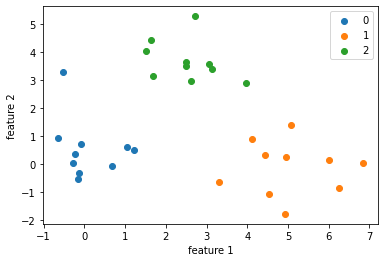

In [16]:
labels_count = np.unique(labels)

import matplotlib.pyplot as plt
for label in np.unique(labels):
  label_mask = (labels == label)
  plt.scatter(features[label_mask, 0], features[label_mask, 1], label=f'{label}')
plt.legend()
plt.xlabel('feature 1'); plt.ylabel('feature 2')
plt.show()

##(2) (20점) 입력 뉴런 2개 - 은닉 뉴런 5개 - 출력 뉴런 3개의 다층 퍼셉트론을 구성하고 학습을 수행한 후 학습된 신경망의 결정경계를 학습 데이터와 함께 2차원 평면에 그리시오.
    (※ 결정경계 계산 시 meshgrid 범위:
    [x, y] = meshgrid([-1:0.1:7], [-2:0.1:6]);)

###하이퍼볼릭탄젠트, 시그모이드, MLPtest, classifier 함수

In [7]:
def d_tanh(a):
  res = (1-a) * (1+a)
  return res
def d_sigmoid(a):
  res = (1-a) * a
  return res

In [8]:
def MLPtest(Xtst, Ttst, w, w0, v, v0, meshset, Mst):
  N = Xtst.shape[0]
  E = np.zeros([N, 1])
  Ytst = np.zeros([N, Ttst.shape[1]]) #Y는 3차원 백터
  for i in range(N):
    x = Xtst[i,:]; t = Ttst[i,:]
    uh = x @ w + w0
    z = np.tanh(uh)
    uo = z @ v + v0
    y = np.tanh(uo)
    e = y - t
    E[i, 0] = e @ e.T
    if y[0,0] > y[0,1] and y[0,0] > y[0,2]:
      Ytst[i,:] = np.array([1,0,0])
    elif y[0,1] > y[0,0] and y[0,1] > y[0,2]:
      Ytst[i,:] = np.array([0,1,0])
    else:
      Ytst[i,:] = np.array([0,0,1])
  SEtst = sum(E**2 ) / N
  SEtst01 = sum(E) / N
  diffTY = sum(abs(Ttst - Ytst)) / 2
  CEtst = diffTY[0] / N
  
  N_mesh = meshset.shape[0]
  Zval_loc = np.zeros([N_mesh,1])
  for i in range(N_mesh):
      x = meshset[i,:]
      uh = x @ w + w0
      z = np.tanh(uh)
      uo = z @ v + v0
      y = np.tanh(uo)
      if y[0,0] > y[0,1] and y[0,0] > y[0,2]:
        Zval_loc[i,:] = 1
      elif y[0,1] > y[0,0] and y[0,1] > y[0,2]:
        Zval_loc[i,:] = 2
      else:
        Zval_loc[i,:] = 3

  return SEtst, CEtst, SEtst01, Ytst, Zval_loc

###학습 with MLPtest

In [9]:
#매쉬그리드 데이터 생성
x_m, y_m = np.arange(-1, 7, 0.1), np.arange(-2, 6, 0.1)
x_m, y_m = np.meshgrid(x_m, y_m)
x1, y1 = np.reshape(x_m, (-1,1), order='F'), np.reshape(y_m, (-1,1), order='F')
XY_m = np.hstack([x1,y1])
x_m.shape, x1.shape, XY_m.shape

((80, 80), (6400, 1), (6400, 2))

In [10]:
N = features.shape[0]
INP, HID, OUT = 2, 5, 3

w = np.random.rand(INP,HID)*0.4 - 0.2
w0 = np.random.rand(1, HID)*0.4 - 0.2
v = np.random.rand(HID,OUT)*0.4 - 0.2
v0 = np.random.rand(1, OUT)*0.4 - 0.2
eta = 0.001
Mstep = 1000; Elimit = 0.05 #################################################################엠스텝
Serr, Cerr, Serr1 = np.zeros([Mstep-1,1]), np.zeros([Mstep-1,1]), np.zeros([Mstep-1,1])

for j in range(1, Mstep):
  E = np.zeros([N,1])
  for i in range(N):
    x = features[i,:]; t = labels_onehot[i,:]
    uh = x @ w + w0
    z = np.tanh(uh)
    uo = z @ v + v0
    y = np.tanh(uo)
    e = y - t
    E[i, 0] = e @ e.T
    delta_v = d_tanh(y) * e
    delta_w = d_tanh(z) * (delta_v @ v.T)
    v = v - eta * (z.T @ delta_v)
    v0 = v0 - eta * (1 * delta_v)
    w = w - eta * (x.reshape(-1,1) @ delta_w)
    w0 = w0 - eta * (1 * delta_w)
  serr, cerr, serr1, Yres, Zval = MLPtest(features, labels_onehot, w, w0, v, v0, XY_m, j) #Yres 분류된라벨값  #Zval Yres의 컨투어벨류
  Serr[j-1,:] = serr; Cerr[j-1,:] = cerr; Serr1[j-1,:] = serr1
  if (serr < Elimit): break
print(j, 'serr: {} | serr1: {} | cerr: {}'.format(serr, serr1, cerr))
print(np.unique(Zval, return_counts=True))

297 serr: [0.04992962] | serr1: [0.16173465] | cerr: 0.016666666666666666
(array([1., 2., 3.]), array([1017, 2335, 3048]))


###결정 경계 그리기

In [11]:
def drawChart(_dataset, a=None, b=None, c=None):
  _labels = _dataset[:,1]
  for i, j in zip(_dataset, range(_dataset.shape[0])):
    if i[2] == 1 and i[3] == 0:
      c1 = j
    elif i[2] == 0 and i[3] == 1:
      c2 = j
    else:
      c3 = j
  plt.scatter(_dataset[0:c1+1,0], _dataset[0:c1+1,1])
  plt.scatter(_dataset[c1+1:c2+1,0], _dataset[c1+1:c2+1,1])
  plt.scatter(_dataset[c2+1:c3+1,0], _dataset[c2+1:c3+1,1])
  if a is not None:
    plt.contour(a, b, np.reshape(c, x_m.shape, order='F'))
  plt.axis([-1, 7, -2, 6]); 
  plt.xlabel('feature 1'); plt.ylabel('feature 2')
  plt.show()


In [12]:
features.shape, labels.shape, type(labels)

((30, 2), (30,), numpy.ndarray)

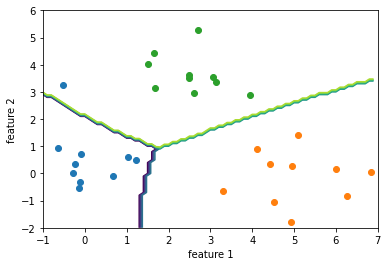

In [13]:
dataset = np.hstack((features, labels_onehot))

drawChart(dataset, x_m, y_m, Zval)

###(3) (20점) 2.(2)에서 학습된 신경망을 이용하여 아래 4개 데이터에 대한 분류를 수행하시오. 단, Matlab 코드를 이용하여 출력 뉴런에서의 출력값을 계산한 후 분류하여야 함.  
데이터 1: 입력 (0, 0)  데이터 2: 입력 (3, 0)  데이터 3: 입력 (6, 0)  데이터 4: 입력 (3, 3)

In [14]:
def classifier(testD, w, w0, v, v0,):
  N_testD = testD.shape[0]
  Zval_loc = np.zeros([N_testD,1])
  for i in range(N_testD):
      x = testD[i,:]
      uh = x @ w + w0
      z = np.tanh(uh)
      uo = z @ v + v0
      y = np.tanh(uo)
      if y[0,0] > y[0,1] and y[0,0] > y[0,2]:
        Zval_loc[i,:] = 1
      elif y[0,1] > y[0,0] and y[0,1] > y[0,2]:
        Zval_loc[i,:] = 2
      else:
        Zval_loc[i,:] = 3
  return Zval_loc

In [18]:
testData = np.array([[0,0], [3,0], [6,0], [3,3]])

resultClass = classifier(testData, w, w0, v, v0)

for i in range(testData.shape[0]):
  print('{} 분류 결과는 클래스 {}'.format(testData[i], int(resultClass[i])))

[0 0] 분류 결과는 클래스 1
[3 0] 분류 결과는 클래스 2
[6 0] 분류 결과는 클래스 2
[3 3] 분류 결과는 클래스 3
